## Import data

In [ ]:
from google.colab import drive
drive.mount('/mnt/drive')
import pandas as pd

file_path = '/mnt/drive/MyDrive/creditcard.csv'
df = pd.read_csv(file_path)
print(df.head())
X = df.drop('Class', axis=1)
y = df['Class']

Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.64

##Import module

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from scipy.stats import uniform, loguniform

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


## Split data, apply under sampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(Counter(y_test))

undersampler = RandomUnderSampler(random_state=42, sampling_strategy=0.1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


print(Counter(y_train_resampled))
print(X_train_resampled.shape)
print(y_train_resampled.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)


Counter({0: 56864, 1: 98})
Counter({0: 3940, 1: 394})
(4334, 30)
(4334,)
(4334, 30)


## Tuning hyperparameter and train

In [ ]:
parameters = {
    'n_estimators': range(10, 21),
    'max_depth': [None],
    'min_samples_split': [2, 3]
}


rf = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(rf, parameters,n_iter=5, cv=5, scoring="average_precision")
random_search.fit(X_train_scaled, y_train_resampled)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best AUPRC score:", random_search.best_score_)

best_model = random_search.best_estimator_

y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

Best Hyperparameters: {'n_estimators': 19, 'min_samples_split': 3, 'max_depth': None}
Best AUPRC score: 0.9153009222351971


## AUC ROC curve, Precision Recall curve, Card Precison@100

Test AUPRC: 0.731697337669266


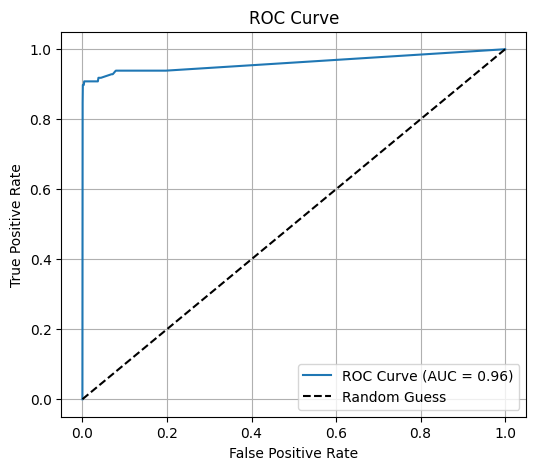

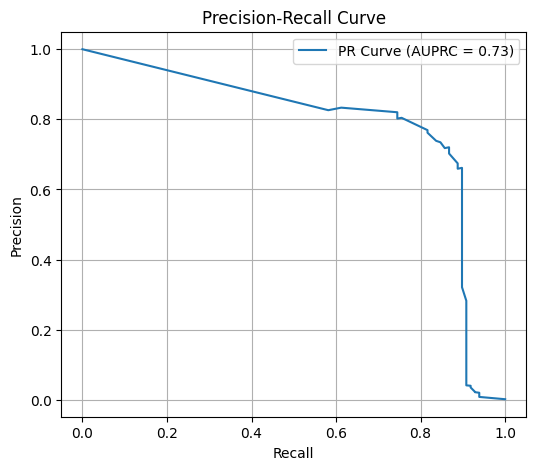

🎯 Card Precision@100: 0.7900 (79 đúng trong top 100)


In [ ]:
from sklearn.metrics import average_precision_score
print("Test AUPRC:", average_precision_score(y_test, y_proba_test))


from sklearn.metrics import roc_curve, auc, precision_recall_curve

# AUC-ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#  Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
pr_auc = average_precision_score(y_test, y_proba_test)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR Curve (AUPRC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


# Card Precision@100 (Precision trong top 100 giao dịch có xác suất gian lận cao nhất)
top_k = 100
top_k_indices = np.argsort(y_proba_test)[-top_k:]
top_k_true = y_test.iloc[top_k_indices]

precision_at_k = top_k_true.sum() / top_k
print(f"🎯 Card Precision@100: {precision_at_k:.4f} ({int(top_k_true.sum())} đúng trong top 100)")


## Confusion matrix and metrics accuracy

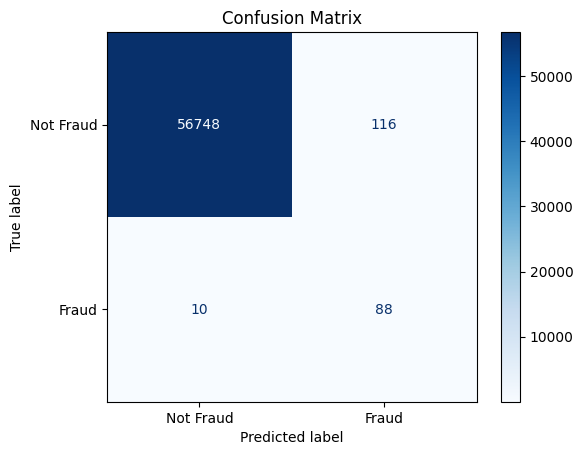


 Accuracy     : 0.9978
 Sensitivity  : 0.8980
 Specificity  : 0.9980
 Precision    : 0.4314
 F1 Score     : 0.5828
 NPV          : 0.9998
 FPR          : 0.0020
 FDR          : 0.5686
 FNR          : 0.1020


In [10]:
y_pred = (y_proba_test >= 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0
precision = tp / (tp + fp) if (tp + fp) else 0
f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) else 0
npv = tn / (tn + fn) if (tn + fn) else 0
fpr = fp / (fp + tn) if (fp + tn) else 0
fdr = fp / (tp + fp) if (tp + fp) else 0
fnr = fn / (fn + tp) if (fn + tp) else 0


print(f"\n Accuracy     : {accuracy:.4f}")
print(f" Sensitivity  : {sensitivity:.4f}")
print(f" Specificity  : {specificity:.4f}")
print(f" Precision    : {precision:.4f}")
print(f" F1 Score     : {f1:.4f}")
print(f" NPV          : {npv:.4f}")
print(f" FPR          : {fpr:.4f}")
print(f" FDR          : {fdr:.4f}")
print(f" FNR          : {fnr:.4f}")
